In [3]:
import pandas as pd
import string
import numpy as np
import json
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras_preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.models import Sequential
import keras.utils as ku
import re
import spacy
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import os
from keras.preprocessing import text
from keras.layers import Embedding, Flatten, Dense, LSTM, Dropout, Bidirectional, Conv1D, MaxPooling1D
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

from keras.models import load_model

import nltk
nltk.download('stopwords')
nltk.download('words')

# import seaborn as sns
# from sklearn import metrics
# from sklearn.model_selection import train_test_split
# import random
# import matplotlib.pyplot as plt

import tensorflow as tf
tf.random.set_seed(2)
from numpy.random import seed
seed(1)

import openai

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\dan\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [ ]:
# https://www.analyticsvidhya.com/blog/2021/09/building-a-machine-learning-model-for-title-generation/
# https://medium.com/analytics-vidhya/predicting-the-ratings-of-reviews-of-a-hotel-using-machine-learning-bd756e6a9b9b
# https://medium.com/analytics-vidhya/neural-networks-for-word-embeddings-4b49e0e9c955
# https://towardsdatascience.com/word2vec-explained-49c52b4ccb71

In [120]:
#load all the datasets 
path = '/Users/dan/YTTnT/archive_1/'
df1 = pd.read_csv(path + 'USvideos.csv')
df2 = pd.read_csv(path + 'CAvideos.csv')
df3 = pd.read_csv(path + 'GBvideos.csv')

#load the datasets containing the category names
data1 = json.load(open(path + 'US_category_id.json'))
data2 = json.load(open(path + 'CA_category_id.json'))
data3 = json.load(open(path + 'GB_category_id.json'))

path1 = '/Users/dan/YTTnT/archive/'

df4 = pd.read_csv(path1 + 'US_youtube_trending_data.csv')
df5 = pd.read_csv(path1 + 'CA_youtube_trending_data.csv')
df6 = pd.read_csv(path1 + 'GB_youtube_trending_data.csv')

data4 = json.load(open(path1 + 'US_category_id.json'))
data5 = json.load(open(path1 + 'CA_category_id.json'))
data6 = json.load(open(path1 + 'GB_category_id.json'))

In [121]:
def category_extractor(data):
    i_d = [data['items'][i]['id'] for i in range(len(data['items']))]
    title = [data['items'][i]['snippet']["title"] for i in range(len(data['items']))]
    i_d = list(map(int, i_d))
    category = zip(i_d, title)
    category = dict(category)
    return category

cat1 = category_extractor(data1)
cat2 = category_extractor(data2)
cat3 = category_extractor(data3)
cat4 = category_extractor(data4)
cat5 = category_extractor(data5)
cat6 = category_extractor(data6)

cat = {**cat1, **cat2, **cat3, **cat4, **cat5, **cat6}

#create a new category column by mapping the category names to their id
df1['category_title'] = df1['category_id'].map(category_extractor(data1))
df2['category_title'] = df2['category_id'].map(category_extractor(data2))
df3['category_title'] = df3['category_id'].map(category_extractor(data3))
df4['category_title'] = df4['categoryId'].map(category_extractor(data4))
df5['category_title'] = df5['categoryId'].map(category_extractor(data5))
df6['category_title'] = df6['categoryId'].map(category_extractor(data6))

#join the dataframes
df = pd.concat([df1, df2, df3, df4, df5, df6], ignore_index=True)

#drop rows based on duplicate videos
df = df.drop_duplicates('video_id')

del df1
del df2
del df3
del df4
del df5
del df6

print(list(cat.values()))

['Film & Animation', 'Autos & Vehicles', 'Music', 'Pets & Animals', 'Sports', 'Short Movies', 'Travel & Events', 'Gaming', 'Videoblogging', 'People & Blogs', 'Comedy', 'Entertainment', 'News & Politics', 'Howto & Style', 'Education', 'Science & Technology', 'Nonprofits & Activism', 'Movies', 'Anime/Animation', 'Action/Adventure', 'Classics', 'Comedy', 'Documentary', 'Drama', 'Family', 'Foreign', 'Horror', 'Sci-Fi/Fantasy', 'Thriller', 'Shorts', 'Shows', 'Trailers']


In [4]:
target_category = 'Science & Technology'

#collect only titles of entertainment videos
#feel free to use any category of video that you want
data = df[df['category_title'] == target_category]

In [5]:
apposV2 = {
"are not" : "are not",
"ca" : "can",
"could n't" : "could not",
"did n't" : "did not",
"does n't" : "does not",
"do n't" : "do not",
"had n't" : "had not",
"has n't" : "has not",
"have n't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"is n't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"might n't" : "might not",
"must n't" : "must not",
"sha" : "shall",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"should n't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"were n't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"wo" : "will",
"would n't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"was n't": "was not",
"we'll":"we will",
"did n't": "did not"
}
appos = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not"
}

In [122]:
category = pd.DataFrame(set(list(cat.values())), columns=['category'])
category

,category
0,Entertainment
1,Film & Animation
2,Videoblogging
3,Classics
4,Shows
5,Trailers
6,Pets & Animals
7,Howto & Style
8,Education
9,Thriller


In [117]:
category.to_csv('Data/category.csv')

In [78]:
cat_str = 'Anime/Animation'.split('/')[0]
print(cat_str)
cat_str = cat_str.split()

Anime


In [189]:
category = 'Comedy'

In [250]:
import string

for category in cat.values(): 
    cat_str = str(category.strip(string.punctuation)).split()[0]
    cat_str = cat_str.split('/')[0]
    titles = cleanTitles(df['title'][df['category_title'] == category])
    np.savetxt('Data/' + cat_str + '.csv', np.array(title_wout_stop), fmt='%s')
    #data = df['cleaned_title'][df['category_title'] == category]
    i = 0
    for ele in data:
        if ele is not None:
            i = i + 1
    if i > 100:
        tokenizer = Tokenizer()
        get_sequence_of_tokens(titles, tokenizer)
        np.savetxt('Data/' + cat_str + '_keys.csv', np.array(list(tokenizer.word_index.keys())), fmt='%s')
    else:
        print('Insufficient # of Samples ' + cat_str)

 42%|████████████████████████████████▌                                            | 1319/3124 [00:02<00:03, 520.92it/s]


KeyboardInterrupt: 

In [198]:
from tqdm import tqdm

def cleanTitles(titles):
    nlp = spacy.load("en_core_web_sm",disable=['parser','ner'])
    stop = stopwords.words('english')
    #eng = set(nltk.corpus.words.words())
    all_=[]
    all_stop = []
    for title in tqdm(titles):
        lower_case = title.lower() #lower case the text
        lower_case = lower_case.replace(" n't"," not") #correct n't as not
        lower_case = lower_case.replace("."," . ")
        lower_case = ' '.join(word.strip(string.punctuation) for word in lower_case.split()) #remove punctuation
        if lower_case != lower_case.encode('utf8').decode('ascii', 'ignore'):
            all_stop.append('')
            continue
        words = lower_case.split() #split into words
        words = [word for word in words if word.isalpha()] #remove numbers
        split = [apposV2[word] if word in apposV2 else word for word in words] #correct using apposV2 as mentioned above
        split = [appos[word] if word in appos else word for word in split] #correct using appos as mentioned above
        split1 = [word for word in split if word not in stop] #remove stop words
#         reformed = " ".join(split) #join words back to the text
#         doc = nlp(reformed)
#         reformed = " ".join([token.lemma_ for token in doc]) #lemmatiztion
#         all_.append(reformed)
        reformed1 = " ".join(split1) #join words back to the text
        doc1 = nlp(reformed1)
        reformed1 = " ".join([token.lemma_ for token in doc1]) #lemmatiztion
        if reformed1 == '':
            all_stop.append('')
        else: all_stop.append(str(reformed1))
    return all_stop

In [246]:
df['cleaned_title'] = cleanTitles(df['title'])
df.to_csv('Data/data.csv')

100%|███████████████████████████████████████████████████████████████████████████| 92541/92541 [03:15<00:00, 474.53it/s]


In [45]:
tokenizer_wout_stop = Tokenizer()
inp_sequences_wout_stop, total_words_wout_stop = get_sequence_of_tokens(title_wout_stop, tokenizer_wout_stop)

In [18]:
def wordCloud_generator(data, title=None):
    wordcloud = WordCloud(width = 800, height = 800,
                          background_color ='black',
                          min_font_size = 10
                         ).generate(" ".join(data))                      
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(title,fontsize=30)
    plt.show()

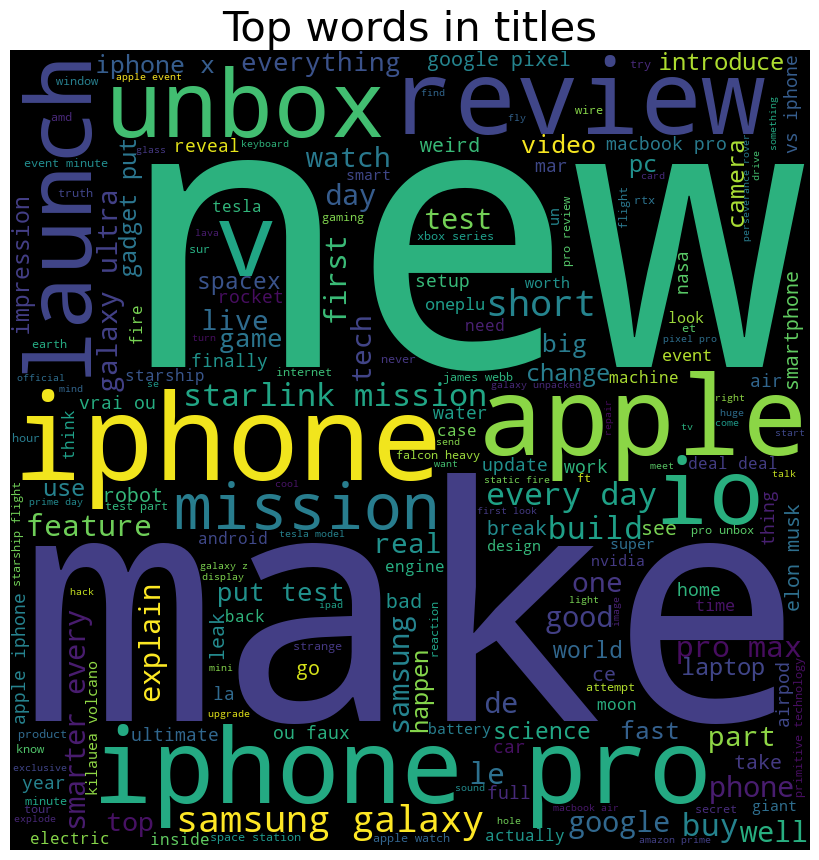

In [23]:
wordCloud_generator(title_wout_stop, title="Top words in titles")

In [9]:
def get_sequence_of_tokens(corpus, tokenizer):
    #get tokens
    tokenizer.fit_on_texts(corpus)
    total_words = len(tokenizer.word_index) + 1

    #convert to sequence of tokens
    max_sequence = 0
    input_sequences = []
    for line in corpus:
        #print(line)
        token_list = tokenizer.texts_to_sequences([line])[0]
        if len(token_list) > max_sequence:
            max_sequence = len(token_list)
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)

    return input_sequences, total_words, max_sequence

In [10]:
def generate_padded_sequences(input_sequences, total_words):
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences,  maxlen=max_sequence_len, padding='pre'))
    predictors, label = input_sequences[:,:-1], input_sequences[:, -1]
    label = ku.to_categorical(label, num_classes = total_words)
    return predictors, label

In [11]:
def create_model(max_sequence_len, total_words):
    input_len = max_sequence_len - 1
    model = Sequential()

    # Add Input Embedding Layer
    model.add(Embedding(total_words, 10, input_length=input_len))

    # Add Hidden Layer 1 — LSTM Layer
    model.add(LSTM(100))
    model.add(Dropout(0.1))

    # Add Output Layer
    model.add(Dense(total_words, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    return model

In [12]:
def generate_text1(seed_text, next_words, model, max_sequence_len, tokenizer):
    
    
    original = seed_text
    
    lower_case = seed_text.lower() #lower case the text
    lower_case = lower_case.replace(" n't"," not") #correct n't as not
    lower_case = lower_case.replace("."," . ")
    lower_case = ' '.join(word.strip(string.punctuation) for word in lower_case.split()) #remove punctuation
    words = lower_case.split() #split into words
    words = [word for word in words if word.isalpha()] #remove numbers
    split = [apposV2[word] if word in apposV2 else word for word in words] #correct using apposV2 as mentioned above
    split = [appos[word] if word in appos else word for word in split] #correct using appos as mentioned above
    split1 = [word for word in split if word not in stop] #remove stop words
    
    
    reformed = " ".join(split) #join words back to the text
    doc = nlp(reformed)
    reformed = " ".join([token.lemma_ for token in doc]) #lemmatiztion
    reformed1 = " ".join(split1) #join words back to the text
    doc1 = nlp(reformed1)
    reformed1 = " ".join([token.lemma_ for token in doc1]) #lemmatiztion

    seed_text = reformed
    
    #output = ''
    
    previous = ''
    
    token_list = tokenizer.texts_to_sequences([seed_text])[0]

    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1,  padding='pre')
    predict_x = model.predict(token_list) 
    predicted_list = np.argsort(predict_x[0])[-next_words:][::-1]

    output_word = ''
    for predicted in predicted_list:
        for word,index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += ' '+output_word
    #output += ' ' + output_word
    
    return seed_text

In [4]:
df = pd.read_csv('Data/data.csv', keep_default_na=False)

C:\Users\dan\AppData\Local\Temp\ipykernel_1944\363346396.py:1: DtypeWarning: Columns (21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Data/data.csv', keep_default_na=False)


In [5]:
set(df['category_title'])

{'',
 'Autos & Vehicles',
 'Comedy',
 'Education',
 'Entertainment',
 'Film & Animation',
 'Gaming',
 'Howto & Style',
 'Movies',
 'Music',
 'News & Politics',
 'Nonprofits & Activism',
 'People & Blogs',
 'Pets & Animals',
 'Science & Technology',
 'Shows',
 'Sports',
 'Travel & Events'}

In [37]:
category_list_all = list(pd.read_csv('Data/category.csv')['category'])

category_list = []

for cat in category_list_all: 
    cat_str = str(cat.strip(string.punctuation)).split()[0]
    cat_str = cat_str.split('/')[0]
    try:
        keys = np.loadtxt('Data/' + cat_str + '_keys.csv', dtype='str')
        category_list.append(cat)
    except:
        pass


In [38]:
list(category_list)

['Entertainment',
 'Film & Animation',
 'Shows',
 'Pets & Animals',
 'Howto & Style',
 'Education',
 'People & Blogs',
 'News & Politics',
 'Science & Technology',
 'Music',
 'Gaming',
 'Travel & Events',
 'Sports',
 'Autos & Vehicles',
 'Comedy']

Entertainment
Epoch 1/75
Epoch 2/75
Epoch 3/75
Epoch 4/75
Epoch 5/75
Epoch 6/75
Epoch 7/75
Epoch 8/75
Epoch 9/75
Epoch 10/75
Epoch 11/75
Epoch 12/75
Epoch 13/75
Epoch 14/75
Epoch 15/75
Epoch 16/75
Epoch 17/75
Epoch 18/75
Epoch 19/75
Epoch 20/75
Epoch 21/75
Epoch 22/75
Epoch 23/75
Epoch 24/75
Epoch 25/75
Epoch 26/75
Epoch 27/75
Epoch 28/75
Epoch 29/75
Epoch 30/75
Epoch 31/75
Epoch 32/75
Epoch 33/75
Epoch 34/75
Epoch 35/75
Epoch 36/75
Epoch 37/75
Epoch 38/75
Epoch 39/75
Epoch 40/75
Epoch 41/75
Epoch 42/75
Epoch 43/75
Epoch 44/75
Epoch 45/75
Epoch 46/75
Epoch 47/75
Epoch 48/75
Epoch 49/75
Epoch 50/75
Epoch 51/75
Epoch 52/75
Epoch 53/75
Epoch 54/75
Epoch 55/75
Epoch 56/75
Epoch 57/75
Epoch 58/75
Epoch 59/75
Epoch 60/75
Epoch 61/75
Epoch 62/75
Epoch 63/75
Epoch 64/75
Epoch 65/75
Epoch 66/75
Epoch 67/75
Epoch 68/75
Epoch 69/75
Epoch 70/75
Epoch 71/75
Epoch 72/75
Epoch 73/75
Epoch 74/75
Epoch 75/75


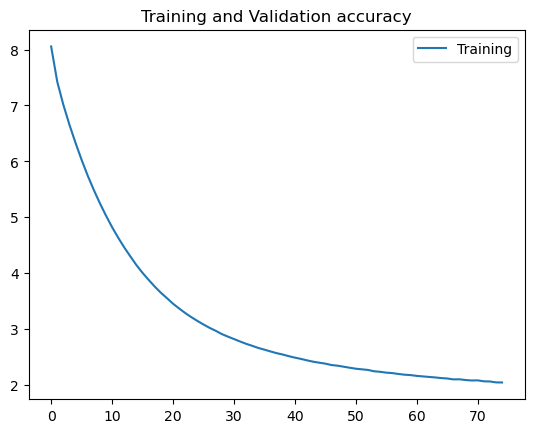

INFO:tensorflow:Assets written to: model_wout_stop_Entertainment_75\assets


INFO:tensorflow:Assets written to: model_wout_stop_Entertainment_75\assets


Film & Animation
Epoch 1/75
Epoch 2/75
Epoch 3/75
Epoch 4/75
Epoch 5/75
Epoch 6/75
Epoch 7/75
Epoch 8/75
Epoch 9/75
Epoch 10/75
Epoch 11/75
Epoch 12/75
Epoch 13/75
Epoch 14/75
Epoch 15/75
Epoch 16/75
Epoch 17/75
Epoch 18/75
Epoch 19/75
Epoch 20/75
Epoch 21/75
Epoch 22/75
Epoch 23/75
Epoch 24/75
Epoch 25/75
Epoch 26/75
Epoch 27/75
Epoch 28/75
Epoch 29/75
Epoch 30/75
Epoch 31/75
Epoch 32/75
Epoch 33/75
Epoch 34/75
Epoch 35/75
Epoch 36/75
Epoch 37/75
Epoch 38/75
Epoch 39/75
Epoch 40/75
Epoch 41/75
Epoch 42/75
Epoch 43/75
Epoch 44/75
Epoch 45/75
Epoch 46/75
Epoch 47/75
Epoch 48/75
Epoch 49/75
Epoch 50/75
Epoch 51/75
Epoch 52/75
Epoch 53/75
Epoch 54/75
Epoch 55/75
Epoch 56/75
Epoch 57/75
Epoch 58/75
Epoch 59/75
Epoch 60/75
Epoch 61/75
Epoch 62/75
Epoch 63/75
Epoch 64/75
Epoch 65/75
Epoch 66/75
Epoch 67/75
Epoch 68/75
Epoch 69/75
Epoch 70/75
Epoch 71/75
Epoch 72/75
Epoch 73/75
Epoch 74/75
Epoch 75/75


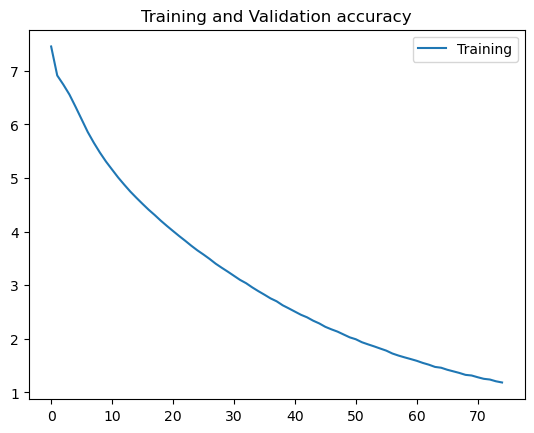

INFO:tensorflow:Assets written to: model_wout_stop_Film & Animation_75\assets


INFO:tensorflow:Assets written to: model_wout_stop_Film & Animation_75\assets


Shows
Epoch 1/75
Epoch 2/75
Epoch 3/75
Epoch 4/75
Epoch 5/75
Epoch 6/75
Epoch 7/75
Epoch 8/75
Epoch 9/75
Epoch 10/75
Epoch 11/75
Epoch 12/75
Epoch 13/75
Epoch 14/75
Epoch 15/75
Epoch 16/75
Epoch 17/75
Epoch 18/75
Epoch 19/75
Epoch 20/75
Epoch 21/75
Epoch 22/75
Epoch 23/75
Epoch 24/75
Epoch 25/75
Epoch 26/75
Epoch 27/75
Epoch 28/75
Epoch 29/75
Epoch 30/75
Epoch 31/75
Epoch 32/75
Epoch 33/75
Epoch 34/75
Epoch 35/75
Epoch 36/75
Epoch 37/75
Epoch 38/75
Epoch 39/75
Epoch 40/75
Epoch 41/75
Epoch 42/75
Epoch 43/75
Epoch 44/75
Epoch 45/75
Epoch 46/75
Epoch 47/75
Epoch 48/75
Epoch 49/75
Epoch 50/75
Epoch 51/75
Epoch 52/75
Epoch 53/75
Epoch 54/75
Epoch 55/75
Epoch 56/75
Epoch 57/75
Epoch 58/75
Epoch 59/75
Epoch 60/75
Epoch 61/75
Epoch 62/75
Epoch 63/75
Epoch 64/75
Epoch 65/75
Epoch 66/75
Epoch 67/75
Epoch 68/75
Epoch 69/75
Epoch 70/75
Epoch 71/75
Epoch 72/75
Epoch 73/75
Epoch 74/75
Epoch 75/75


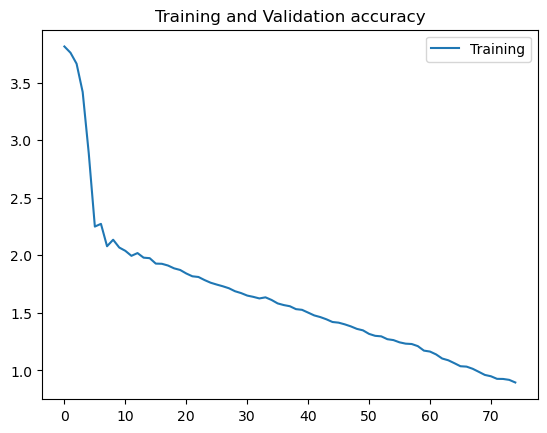

INFO:tensorflow:Assets written to: model_wout_stop_Shows_75\assets


INFO:tensorflow:Assets written to: model_wout_stop_Shows_75\assets


Pets & Animals
Epoch 1/75
Epoch 2/75
Epoch 3/75
Epoch 4/75
Epoch 5/75
Epoch 6/75
Epoch 7/75
Epoch 8/75
Epoch 9/75
Epoch 10/75
Epoch 11/75
Epoch 12/75
Epoch 13/75
Epoch 14/75
Epoch 15/75
Epoch 16/75
Epoch 17/75
Epoch 18/75
Epoch 19/75
Epoch 20/75
Epoch 21/75
Epoch 22/75
Epoch 23/75
Epoch 24/75
Epoch 25/75
Epoch 26/75
Epoch 27/75
Epoch 28/75
Epoch 29/75
Epoch 30/75
Epoch 31/75
Epoch 32/75
Epoch 33/75
Epoch 34/75
Epoch 35/75
Epoch 36/75
Epoch 37/75
Epoch 38/75
Epoch 39/75
Epoch 40/75
Epoch 41/75
Epoch 42/75
Epoch 43/75
Epoch 44/75
Epoch 45/75
Epoch 46/75
Epoch 47/75
Epoch 48/75
Epoch 49/75
Epoch 50/75
Epoch 51/75
Epoch 52/75
Epoch 53/75
Epoch 54/75
Epoch 55/75
Epoch 56/75
Epoch 57/75
Epoch 58/75
Epoch 59/75
Epoch 60/75
Epoch 61/75
Epoch 62/75


KeyboardInterrupt: 

In [19]:
for target_category in list(category_list):

    print(target_category)
    tokenizer = Tokenizer()
    inp_sequences, total_words, max_sequence_len = get_sequence_of_tokens(df['cleaned_title'][df['category_title'] == target_category], tokenizer)
    predictors, label = generate_padded_sequences(inp_sequences, total_words)
    model_wout_stop = create_model(max_sequence_len, total_words)
    history = model_wout_stop.fit(predictors, label, epochs=75, verbose=4)
    plt.plot(history.history['loss'], label='Training')
# plt.plot(history.history['val_loss'], label='Validation')
# plt.legend()
# plt.title('Training and Validation Loss')
# plt.figure()

    plt.legend()
    plt.title('Training and Validation accuracy')
    plt.show()
    
    model_wout_stop.save('model_wout_stop_{0}_{1}'.format(target_category, 75))

In [23]:
from gensim.models import Word2Vec

target_category = 'Entertainment'

from gensim.models import Phrases

nltk.download('punkt')

from nltk import word_tokenize

# Train a bigram detector.
bigram_transformer = Phrases(df['cleaned_title'][df['category_title'] == target_category])

print(target_category)
# tokenizer = Tokenizer()
# inp_sequences, total_words, max_sequence_len = get_sequence_of_tokens(bigram_transformer[df['cleaned_title'][df['category_title'] == target_category]], tokenizer)
#predictors, label = generate_padded_sequences(inp_sequences, total_words)

#print(inp_sequences)
titles = [word_tokenize(title) for title in df['cleaned_title'][df['category_title'] == target_category]]

model = Word2Vec(titles, vector_size=100, window=5, min_count=1, workers=4)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dan\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


Entertainment


In [35]:
#print(model.wv.most_similar('hi'))
#print(model.wv.most_similar(positive = ['hi'], topn=20) )

model.wv.key_to_index.keys()

dict_keys(['episode', 'trailer', 'official', 'vs', 'get', 'season', 'new', 'full', 'video', 'ep', 'react', 'challenge', 'show', 'short', 'live', 'day', 'make', 'good', 'go', 'movie', 'man', 'ft', 'drama', 'reaction', 'star', 'hd', 'news', 'first', 'try', 'tv', 'part', 'life', 'music', 'top', 'last', 'war', 'house', 'one', 'game', 'talk', 'netflix', 'time', 'review', 'world', 'thing', 'test', 'juan', 'love', 'teaser', 'bad', 'hour', 'eat', 'people', 'break', 'transfer', 'utd', 'united', 'big', 'food', 'reveal', 'know', 'kid', 'explain', 'real', 'christmas', 'open', 'watch', 'say', 'home', 'family', 'ever', 'voice', 'audition', 'promo', 'take', 'meet', 'may', 'goldbridge', 'end', 'x', 'black', 'year', 'look', 'match', 'play', 'crime', 'john', 'ka', 'secret', 'breakdown', 'manchester', 'digital', 'we', 'patrol', 'week', 'back', 'e', 'snl', 'friend', 'baby', 'question', 'interview', 'american', 'ary', 'de', 'moment', 'youtube', 'harry', 'story', 'win', 'hot', 'buy', 'super', 'night', 'batt

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Entertainment
17851
132.0
Epoch: 1	  Loss: 289929.4375
Epoch: 2	  Loss: 507392.53125
Epoch: 3	  Loss: 682717.9375
Epoch: 4	  Loss: 852269.375
Epoch: 5	  Loss: 1015918.3125
Epoch: 6	  Loss: 1166075.0
Epoch: 7	  Loss: 1301992.0
Epoch: 8	  Loss: 1432508.125
Epoch: 9	  Loss: 1556704.25
Epoch: 10	  Loss: 1676298.5
Epoch: 11	  Loss: 1802029.75
Epoch: 12	  Loss: 1926684.0
Epoch: 13	  Loss: 2033190.625
Epoch: 14	  Loss: 2148140.75
Epoch: 15	  Loss: 2246502.75
Epoch: 16	  Loss: 2340065.25
Epoch: 17	  Loss: 2433758.75
Epoch: 18	  Loss: 2523863.5
Epoch: 19	  Loss: 2611216.25
Epoch: 20	  Loss: 2708659.0
Epoch: 21	  Loss: 2795022.25
Epoch: 22	  Loss: 2879063.75
Epoch: 23	  Loss: 2963855.25
Epoch: 24	  Loss: 3046984.0
Epoch: 25	  Loss: 3127825.75
Epoch: 26	  Loss: 3209756.25
Epoch: 27	  Loss: 3299163.0
Epoch: 28	  Loss: 3383308.75
Epoch: 29	  Loss: 3460458.75
Epoch: 30	  Loss: 3538079.5
Epoch: 31	  Loss: 3618086.75
Epoch: 32	  Loss: 3694266.5
Epoch: 33	  Loss: 3769594.5
Epoch: 34	  Loss: 3843951.0
E

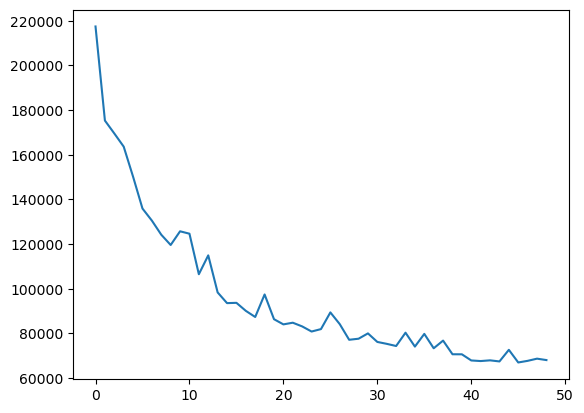

Film & Animation
2485
48.0
Epoch: 1	  Loss: 83155.6328125
Epoch: 2	  Loss: 160503.515625
Epoch: 3	  Loss: 223752.890625
Epoch: 4	  Loss: 279387.9375
Epoch: 5	  Loss: 331440.03125
Epoch: 6	  Loss: 381827.0
Epoch: 7	  Loss: 429098.5
Epoch: 8	  Loss: 473603.375
Epoch: 9	  Loss: 516821.90625
Epoch: 10	  Loss: 558490.625
Epoch: 11	  Loss: 599320.875
Epoch: 12	  Loss: 638313.75
Epoch: 13	  Loss: 676253.0625
Epoch: 14	  Loss: 713211.5625
Epoch: 15	  Loss: 748388.6875
Epoch: 16	  Loss: 783209.875
Epoch: 17	  Loss: 817334.625
Epoch: 18	  Loss: 849990.25
Epoch: 19	  Loss: 882649.8125
Epoch: 20	  Loss: 914126.375
Epoch: 21	  Loss: 944811.3125
Epoch: 22	  Loss: 974846.5625
Epoch: 23	  Loss: 1004584.625
Epoch: 24	  Loss: 1033673.625
Epoch: 25	  Loss: 1062000.5
Epoch: 26	  Loss: 1089664.25
Epoch: 27	  Loss: 1117252.625
Epoch: 28	  Loss: 1144330.5
Epoch: 29	  Loss: 1170379.0
Epoch: 30	  Loss: 1196580.625
Epoch: 31	  Loss: 1222034.625
Epoch: 32	  Loss: 1247125.75
Epoch: 33	  Loss: 1272263.375
Epoch: 3

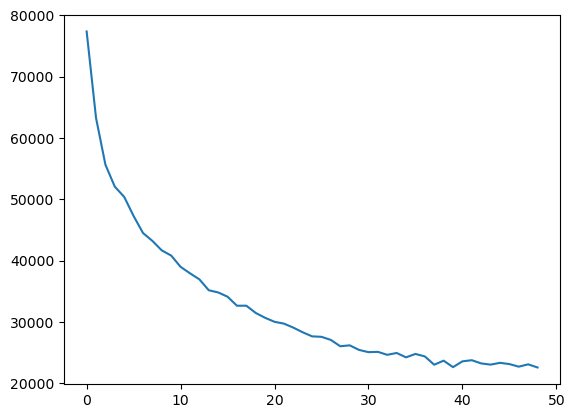

Insufficient # of Samples Shows
Pets & Animals
538
24.0
Epoch: 1	  Loss: 10011.3271484375
Epoch: 2	  Loss: 20294.38671875
Epoch: 3	  Loss: 30329.013671875
Epoch: 4	  Loss: 40844.94921875
Epoch: 5	  Loss: 51095.81640625
Epoch: 6	  Loss: 60702.6640625
Epoch: 7	  Loss: 69502.484375
Epoch: 8	  Loss: 77631.46875
Epoch: 9	  Loss: 85118.7578125
Epoch: 10	  Loss: 91746.578125
Epoch: 11	  Loss: 98452.5703125
Epoch: 12	  Loss: 105070.6953125
Epoch: 13	  Loss: 111731.671875
Epoch: 14	  Loss: 118620.140625
Epoch: 15	  Loss: 124573.609375
Epoch: 16	  Loss: 131106.625
Epoch: 17	  Loss: 137550.078125
Epoch: 18	  Loss: 143742.609375
Epoch: 19	  Loss: 149841.359375
Epoch: 20	  Loss: 155849.25
Epoch: 21	  Loss: 161798.609375
Epoch: 22	  Loss: 168017.625
Epoch: 23	  Loss: 174260.828125
Epoch: 24	  Loss: 180447.75
Epoch: 25	  Loss: 186864.4375
Epoch: 26	  Loss: 192505.125
Epoch: 27	  Loss: 198623.203125
Epoch: 28	  Loss: 204786.109375
Epoch: 29	  Loss: 210562.5
Epoch: 30	  Loss: 216543.9375
Epoch: 31	  Lo

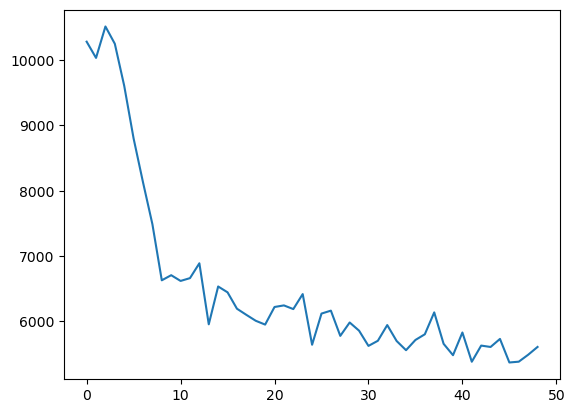

Howto & Style
2971
56.0
Epoch: 1	  Loss: 111247.7421875
Epoch: 2	  Loss: 214356.1875
Epoch: 3	  Loss: 296561.5
Epoch: 4	  Loss: 369996.09375
Epoch: 5	  Loss: 440390.78125
Epoch: 6	  Loss: 507610.125
Epoch: 7	  Loss: 571187.375
Epoch: 8	  Loss: 631818.5
Epoch: 9	  Loss: 689429.25
Epoch: 10	  Loss: 744561.9375
Epoch: 11	  Loss: 797228.4375
Epoch: 12	  Loss: 848519.4375
Epoch: 13	  Loss: 897756.625
Epoch: 14	  Loss: 945636.25
Epoch: 15	  Loss: 992608.25
Epoch: 16	  Loss: 1038167.0625
Epoch: 17	  Loss: 1081933.0
Epoch: 18	  Loss: 1124038.25
Epoch: 19	  Loss: 1165045.125
Epoch: 20	  Loss: 1205475.375
Epoch: 21	  Loss: 1243919.375
Epoch: 22	  Loss: 1282275.5
Epoch: 23	  Loss: 1320048.125
Epoch: 24	  Loss: 1356389.75
Epoch: 25	  Loss: 1393015.625
Epoch: 26	  Loss: 1428600.5
Epoch: 27	  Loss: 1463652.375
Epoch: 28	  Loss: 1497657.875
Epoch: 29	  Loss: 1531036.375
Epoch: 30	  Loss: 1564338.375
Epoch: 31	  Loss: 1597258.75
Epoch: 32	  Loss: 1629989.5
Epoch: 33	  Loss: 1662464.25
Epoch: 34	  Loss

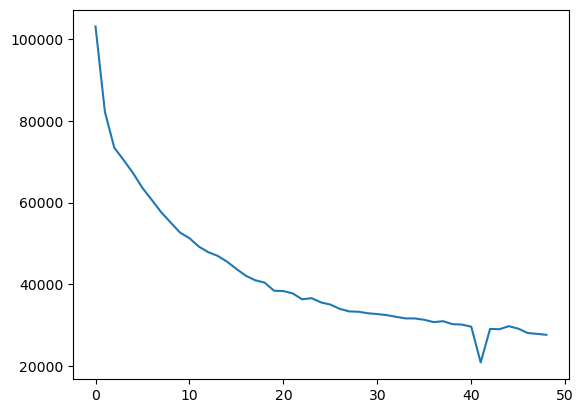

Education
1798
44.0
Epoch: 1	  Loss: 47432.265625
Epoch: 2	  Loss: 96191.140625
Epoch: 3	  Loss: 143495.96875
Epoch: 4	  Loss: 191112.84375
Epoch: 5	  Loss: 238107.078125
Epoch: 6	  Loss: 281067.9375
Epoch: 7	  Loss: 318709.0625
Epoch: 8	  Loss: 352477.40625
Epoch: 9	  Loss: 384882.875
Epoch: 10	  Loss: 416561.125
Epoch: 11	  Loss: 448172.90625
Epoch: 12	  Loss: 479084.59375
Epoch: 13	  Loss: 509893.875
Epoch: 14	  Loss: 539552.4375
Epoch: 15	  Loss: 569729.125
Epoch: 16	  Loss: 599503.8125
Epoch: 17	  Loss: 628669.125
Epoch: 18	  Loss: 657999.0
Epoch: 19	  Loss: 687183.3125
Epoch: 20	  Loss: 715149.625
Epoch: 21	  Loss: 743243.5625
Epoch: 22	  Loss: 770749.6875
Epoch: 23	  Loss: 797692.875
Epoch: 24	  Loss: 825000.6875
Epoch: 25	  Loss: 851384.125
Epoch: 26	  Loss: 877721.25
Epoch: 27	  Loss: 903895.75
Epoch: 28	  Loss: 929665.4375
Epoch: 29	  Loss: 955069.875
Epoch: 30	  Loss: 980147.625
Epoch: 31	  Loss: 1005005.5625
Epoch: 32	  Loss: 1029359.375
Epoch: 33	  Loss: 1053684.25
Epoch: 

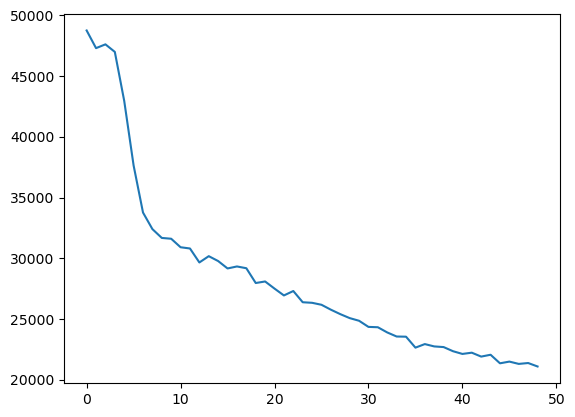

People & Blogs
7080
84.0
Epoch: 1	  Loss: 117019.3125
Epoch: 2	  Loss: 220289.234375
Epoch: 3	  Loss: 304240.75
Epoch: 4	  Loss: 383936.90625
Epoch: 5	  Loss: 456994.4375
Epoch: 6	  Loss: 530016.0
Epoch: 7	  Loss: 600384.875
Epoch: 8	  Loss: 665745.125
Epoch: 9	  Loss: 729687.125
Epoch: 10	  Loss: 790684.1875
Epoch: 11	  Loss: 847707.6875
Epoch: 12	  Loss: 903625.4375
Epoch: 13	  Loss: 956907.6875
Epoch: 14	  Loss: 1007491.5625
Epoch: 15	  Loss: 1056851.625
Epoch: 16	  Loss: 1103792.75
Epoch: 17	  Loss: 1149061.875
Epoch: 18	  Loss: 1192303.0
Epoch: 19	  Loss: 1233657.75
Epoch: 20	  Loss: 1274745.125
Epoch: 21	  Loss: 1313148.75
Epoch: 22	  Loss: 1351148.25
Epoch: 23	  Loss: 1387852.5
Epoch: 24	  Loss: 1423661.25
Epoch: 25	  Loss: 1459491.625
Epoch: 26	  Loss: 1494111.5
Epoch: 27	  Loss: 1527756.0
Epoch: 28	  Loss: 1560311.75
Epoch: 29	  Loss: 1592595.375
Epoch: 30	  Loss: 1623881.75
Epoch: 31	  Loss: 1655599.75
Epoch: 32	  Loss: 1685981.75
Epoch: 33	  Loss: 1716343.75
Epoch: 34	  Loss

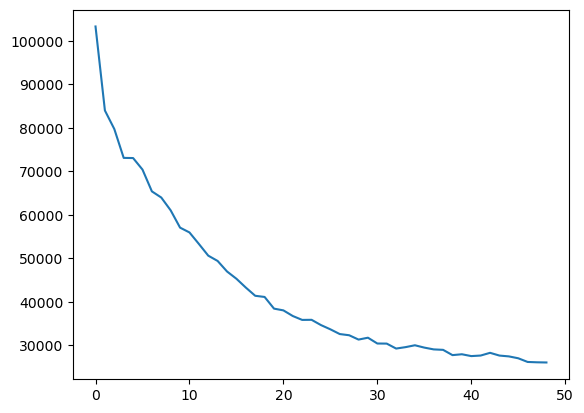

News & Politics
4797
68.0
Epoch: 1	  Loss: 182266.0625
Epoch: 2	  Loss: 305584.65625
Epoch: 3	  Loss: 428533.21875
Epoch: 4	  Loss: 545483.3125
Epoch: 5	  Loss: 658784.0625
Epoch: 6	  Loss: 767739.4375
Epoch: 7	  Loss: 855363.6875
Epoch: 8	  Loss: 955405.8125
Epoch: 9	  Loss: 1051840.375
Epoch: 10	  Loss: 1144932.0
Epoch: 11	  Loss: 1233280.5
Epoch: 12	  Loss: 1318938.875
Epoch: 13	  Loss: 1401374.125
Epoch: 14	  Loss: 1469034.0
Epoch: 15	  Loss: 1545598.75
Epoch: 16	  Loss: 1620709.875
Epoch: 17	  Loss: 1692249.0
Epoch: 18	  Loss: 1763415.75
Epoch: 19	  Loss: 1831823.125
Epoch: 20	  Loss: 1899120.125
Epoch: 21	  Loss: 1964529.375
Epoch: 22	  Loss: 2028994.75
Epoch: 23	  Loss: 2091768.625
Epoch: 24	  Loss: 2151248.0
Epoch: 25	  Loss: 2209982.75
Epoch: 26	  Loss: 2267790.0
Epoch: 27	  Loss: 2324571.5
Epoch: 28	  Loss: 2380297.0
Epoch: 29	  Loss: 2435865.75
Epoch: 30	  Loss: 2490190.75
Epoch: 31	  Loss: 2543900.25
Epoch: 32	  Loss: 2597323.0
Epoch: 33	  Loss: 2650924.0
Epoch: 34	  Loss: 

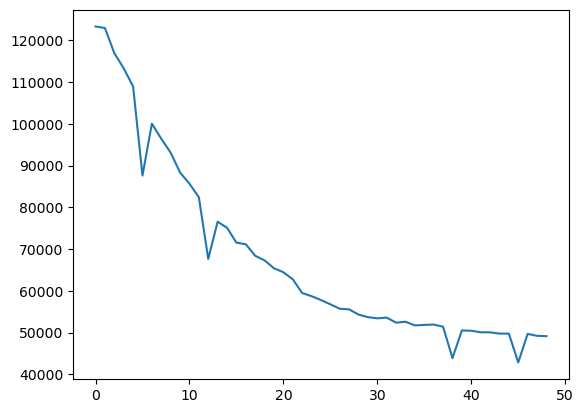

Science & Technology
2246
48.0
Epoch: 1	  Loss: 80109.3828125
Epoch: 2	  Loss: 160436.21875
Epoch: 3	  Loss: 230776.90625
Epoch: 4	  Loss: 288525.5
Epoch: 5	  Loss: 342176.21875
Epoch: 6	  Loss: 394127.6875
Epoch: 7	  Loss: 444254.6875
Epoch: 8	  Loss: 493320.40625
Epoch: 9	  Loss: 540412.4375
Epoch: 10	  Loss: 585965.5625
Epoch: 11	  Loss: 630000.1875
Epoch: 12	  Loss: 673460.375
Epoch: 13	  Loss: 715844.625
Epoch: 14	  Loss: 756452.875
Epoch: 15	  Loss: 796247.8125
Epoch: 16	  Loss: 834052.5
Epoch: 17	  Loss: 871507.75
Epoch: 18	  Loss: 907745.6875
Epoch: 19	  Loss: 943672.0
Epoch: 20	  Loss: 978650.375
Epoch: 21	  Loss: 1012834.5
Epoch: 22	  Loss: 1046611.4375
Epoch: 23	  Loss: 1079828.375
Epoch: 24	  Loss: 1111795.875
Epoch: 25	  Loss: 1142801.875
Epoch: 26	  Loss: 1173105.5
Epoch: 27	  Loss: 1203258.75
Epoch: 28	  Loss: 1232888.5
Epoch: 29	  Loss: 1262091.125
Epoch: 30	  Loss: 1291274.875
Epoch: 31	  Loss: 1319944.375
Epoch: 32	  Loss: 1348143.75
Epoch: 33	  Loss: 1375802.125
Epoc

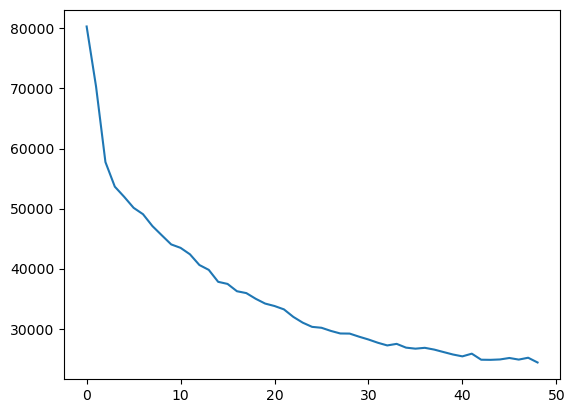

Music
8808
92.0
Epoch: 1	  Loss: 111900.484375
Epoch: 2	  Loss: 196023.890625
Epoch: 3	  Loss: 272079.65625
Epoch: 4	  Loss: 335563.59375
Epoch: 5	  Loss: 401945.78125
Epoch: 6	  Loss: 457227.25
Epoch: 7	  Loss: 517973.09375
Epoch: 8	  Loss: 572570.0625
Epoch: 9	  Loss: 627035.0625
Epoch: 10	  Loss: 673650.25
Epoch: 11	  Loss: 720655.0
Epoch: 12	  Loss: 766974.125
Epoch: 13	  Loss: 808045.0625
Epoch: 14	  Loss: 852775.6875
Epoch: 15	  Loss: 894572.5625
Epoch: 16	  Loss: 933821.4375
Epoch: 17	  Loss: 972515.0625
Epoch: 18	  Loss: 1008310.0
Epoch: 19	  Loss: 1046433.6875
Epoch: 20	  Loss: 1082511.625
Epoch: 21	  Loss: 1117904.625
Epoch: 22	  Loss: 1149511.375
Epoch: 23	  Loss: 1180620.125
Epoch: 24	  Loss: 1210923.375
Epoch: 25	  Loss: 1240527.0
Epoch: 26	  Loss: 1269531.0
Epoch: 27	  Loss: 1301859.625
Epoch: 28	  Loss: 1333926.625
Epoch: 29	  Loss: 1364201.125
Epoch: 30	  Loss: 1392784.375
Epoch: 31	  Loss: 1424515.5
Epoch: 32	  Loss: 1452523.875
Epoch: 33	  Loss: 1482574.0
Epoch: 34	  

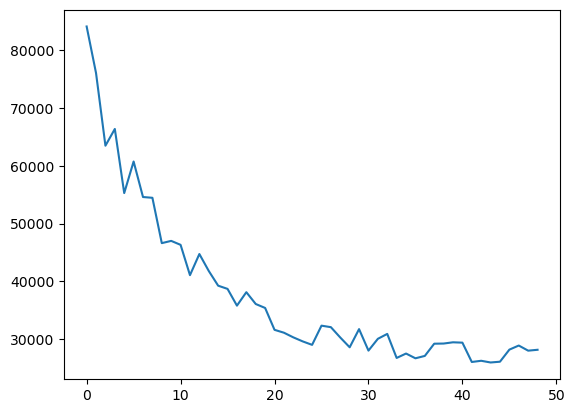

Gaming
9329
96.0
Epoch: 1	  Loss: 116807.8515625
Epoch: 2	  Loss: 198288.171875
Epoch: 3	  Loss: 278136.15625
Epoch: 4	  Loss: 345176.78125
Epoch: 5	  Loss: 413701.6875
Epoch: 6	  Loss: 475181.96875
Epoch: 7	  Loss: 533584.3125
Epoch: 8	  Loss: 593342.875
Epoch: 9	  Loss: 647727.9375
Epoch: 10	  Loss: 703534.0
Epoch: 11	  Loss: 756387.8125
Epoch: 12	  Loss: 806030.0625
Epoch: 13	  Loss: 855591.875
Epoch: 14	  Loss: 901930.6875
Epoch: 15	  Loss: 945695.875
Epoch: 16	  Loss: 988077.25
Epoch: 17	  Loss: 1033020.3125
Epoch: 18	  Loss: 1076534.375
Epoch: 19	  Loss: 1115507.25
Epoch: 20	  Loss: 1157966.875
Epoch: 21	  Loss: 1199209.125
Epoch: 22	  Loss: 1235678.875
Epoch: 23	  Loss: 1275638.0
Epoch: 24	  Loss: 1313761.625
Epoch: 25	  Loss: 1347862.5
Epoch: 26	  Loss: 1384501.875
Epoch: 27	  Loss: 1418591.5
Epoch: 28	  Loss: 1452518.125
Epoch: 29	  Loss: 1488937.125
Epoch: 30	  Loss: 1523320.5
Epoch: 31	

In [ ]:
from gensim.models import Word2Vec
from gensim.models import Phrases
nltk.download('punkt')
from nltk import word_tokenize
import string

import gensim
from gensim.models.callbacks import CallbackAny2Vec

# Your model params:
CONTEXT_WINDOW = 50
NEGATIVES = 5
MIN_COUNT = 3
EPOCHS = 50

class LossLogger(CallbackAny2Vec):
    '''Output loss at each epoch'''
    def __init__(self):
        self.epoch = 1
        self.losses = []

    def on_epoch_begin(self, model):
        print(f'Epoch: {self.epoch}', end='\t')

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        self.losses.append(loss)
        print(f'  Loss: {loss}')
        self.epoch += 1

for j, category in enumerate(category_list): 
    cat_str = str(category.strip(string.punctuation)).split()[0]
    cat_str = cat_str.split('/')[0]
    #titles = cleanTitles(df['title'][df['category_title'] == category])
    #np.savetxt('Data/' + cat_str + '.csv', np.array(title_wout_stop), fmt='%s')
    #data = df['cleaned_title'][df['category_title'] == category]
    i = 0
    for ele in df['cleaned_title'][df['category_title'] == category]:
        if ele != '':
            i = i + 1
    if i > 100:
        # Train a bigram detector.
        bigram_transformer = Phrases(df['cleaned_title'][df['category_title'] == category])

        print(category)
        # tokenizer = Tokenizer()
        # inp_sequences, total_words, max_sequence_len = get_sequence_of_tokens(bigram_transformer[df['cleaned_title'][df['category_title'] == target_category]], tokenizer)
        #predictors, label = generate_padded_sequences(inp_sequences, total_words)

        #print(inp_sequences)
        titles = [word_tokenize(title) for title in df['cleaned_title'][df['category_title'] == category]]

        loss_logger = LossLogger()
        print(i)
        print(np.round(np.sqrt(i)/4.0) * 4)
        model = gensim.models.word2vec.Word2Vec(titles,
                                      vector_size=int(np.sqrt(i)/4) * 4,
                                      sg=1,
                                      window=CONTEXT_WINDOW,
                                      workers=8,
                                      negative=NEGATIVES,
                                      min_count=MIN_COUNT,
                                      callbacks=[loss_logger],
                                      compute_loss=True,
                                      epochs=EPOCHS)
        
        plt.plot(np.diff(loss_logger.losses))
        plt.show()
        model.wv.save('{0}.kv'.format(category))
    else:
        print('Insufficient # of Samples ' + cat_str)

In [40]:
category_list

['Entertainment',
 'Film & Animation',
 'Shows',
 'Pets & Animals',
 'Howto & Style',
 'Education',
 'People & Blogs',
 'News & Politics',
 'Science & Technology',
 'Music',
 'Gaming',
 'Travel & Events',
 'Sports',
 'Autos & Vehicles',
 'Comedy']

In [ ]:
from gensim.models import KeyedVectors
reloaded_word_vectors = KeyedVectors.load('Entertainment.kv')
rel

In [278]:
model_wout_stop = create_model(max_sequence_len, total_words)
history = model_wout_stop.fit(predictors, label, epochs=75, verbose=5)

Epoch 1/200
Epoch 2/200
Epoch 3/200
Epoch 4/200
Epoch 5/200
Epoch 6/200
Epoch 7/200
Epoch 8/200
Epoch 9/200
Epoch 10/200
Epoch 11/200
Epoch 12/200
Epoch 13/200
Epoch 14/200
Epoch 15/200
Epoch 16/200
Epoch 17/200
Epoch 18/200
Epoch 19/200
Epoch 20/200
Epoch 21/200
Epoch 22/200
Epoch 23/200
Epoch 24/200
Epoch 25/200
Epoch 26/200
Epoch 27/200
Epoch 28/200
Epoch 29/200
Epoch 30/200
Epoch 31/200
Epoch 32/200
Epoch 33/200
Epoch 34/200
Epoch 35/200
Epoch 36/200
Epoch 37/200
Epoch 38/200
Epoch 39/200
Epoch 40/200
Epoch 41/200
Epoch 42/200
Epoch 43/200
Epoch 44/200
Epoch 45/200
Epoch 46/200
Epoch 47/200
Epoch 48/200
Epoch 49/200
Epoch 50/200
Epoch 51/200
Epoch 52/200
Epoch 53/200
Epoch 54/200
Epoch 55/200
Epoch 56/200
Epoch 57/200
Epoch 58/200
Epoch 59/200
Epoch 60/200
Epoch 61/200
Epoch 62/200
Epoch 63/200
Epoch 64/200
Epoch 65/200
Epoch 66/200
Epoch 67/200
Epoch 68/200
Epoch 69/200
Epoch 70/200
Epoch 71/200
Epoch 72/200
Epoch 73/200
Epoch 74/200
Epoch 75/200
Epoch 76/200
Epoch 77/200
Epoch 78

Text(0.5, 1.0, 'Training and Validation accuracy')

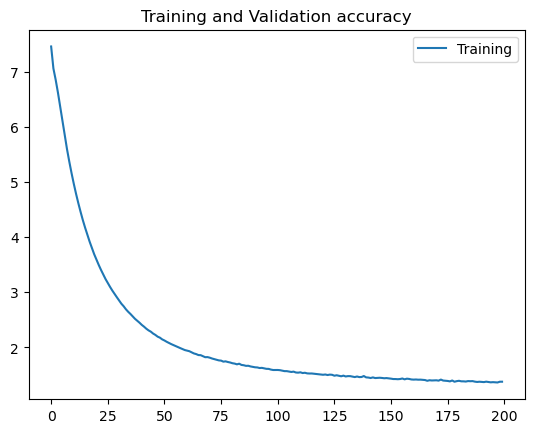

In [279]:
plt.plot(history.history['loss'], label='Training')
# plt.plot(history.history['val_loss'], label='Validation')
# plt.legend()
# plt.title('Training and Validation Loss')
# plt.figure()

plt.legend()
plt.title('Training and Validation accuracy')

In [283]:
# car, buy, race

print(generate_text1("league", 5, model_wout_stop, max_sequence_len, tokenizer))

1/1 [==============================] - 0s 29ms/step
league debut legend season war legacy


In [282]:
model_wout_stop.save('model_wout_stop_{0}_{1}'.format(target_category, 75))

INFO:tensorflow:Assets written to: model_wout_stop_Gaming_200\assets


INFO:tensorflow:Assets written to: model_wout_stop_Gaming_200\assets


In [235]:
def generate_text(seed_text, next_words, model, max_sequence_len, tokenizer):
    
    original = seed_text
    
    lower_case = seed_text.lower() #lower case the text
    lower_case = lower_case.replace(" n't"," not") #correct n't as not
    lower_case = lower_case.replace("."," . ")
    lower_case = ' '.join(word.strip(string.punctuation) for word in lower_case.split()) #remove punctuation
    words = lower_case.split() #split into words
    words = [word for word in words if word.isalpha()] #remove numbers
    split = [apposV2[word] if word in apposV2 else word for word in words] #correct using apposV2 as mentioned above
    split = [appos[word] if word in appos else word for word in split] #correct using appos as mentioned above
    split1 = [word for word in split if word not in stop] #remove stop words
    
    
    reformed = " ".join(split) #join words back to the text
    doc = nlp(reformed)
    reformed = " ".join([token.lemma_ for token in doc]) #lemmatiztion
    reformed1 = " ".join(split1) #join words back to the text
    doc1 = nlp(reformed1)
    reformed1 = " ".join([token.lemma_ for token in doc1]) #lemmatiztion

    seed_text = reformed
    
    # check if word in dictionary
    if not seed_text in words:
        print('bad')
        return 0
    
    
    #output = ''
    previous = ''
    
    for j in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        
#         if j > 0 and not token_list in inp_sequences:
#             print('bad1')
# #             predicted_list = np.argsort(predict_x[0])[-next_words + j:][::-1]
# #             output_word = ''
# #             for predicted in predicted_list:
# #                 for word,index in tokenizer.word_index.items():
# #                     if index == predicted:
# #                         output_word = word
# #                         break
# #                 seed_text += ' '+output_word
#             return seed_text
            
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1,  padding='pre')
        predict_x = model.predict(token_list) 
        predicted = np.argmax(predict_x,axis=-1)
        
        

        output_word = ''
        for word,index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += ' '+output_word
        

        #output += ' ' + output_word
    
        previous = predict_x
        
    return seed_text

In [238]:
print(generate_text("pixel", 20, model, max_sequence_len, tokenizer))

1/1 [==============================] - 0s 48ms/step
pixel pro review this more iphone x iphone pro max pro watch v tech pro repair test to android promise and


In [17]:
# seeds 1 - 10, generate 10 responses from which user can choose

# show list of tokens, by popularity and by alphabetical

# check descriptions as well

In [18]:
# Make each word a class, with category id as a variable within the class
# Handle exceptions for class initialization and functions 
# Functions to Save/load models
# GUI using Streamlit maybe?

In [220]:
words = list(tokenizer.word_index.keys())

In [258]:
print(generate_text1("volcano", 10, model1, max_sequence_len1, tokenizer1))

NameError: name 'model1' is not defined

In [31]:
model_wout_stop.save('model_with_stop_{0}'.format(target_category))

INFO:tensorflow:Assets written to: model_with_stop\assets


INFO:tensorflow:Assets written to: model_with_stop\assets


INFO:tensorflow:Assets written to: model_wout_stop\assets


INFO:tensorflow:Assets written to: model_wout_stop\assets
